

# Project: Investigate a Dataset - European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limitations">Limitations</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This soccer database comes from Kaggle with quite extensive data stored in SQLite database. It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016.



### Questions for Analysis

Through this notebook, we will seek to answer the following questions:
* Do home teams have more chances of winning matches?
* What are the top winning teams?
* What are the team attributes contributing the most in a winning team?
* Who are the top rated players among the world? are they playing in the top winning teams?

In [34]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


<a id='wrangling'></a>
## Data Wrangling

Through this section, the data shall be loaded, explored and cleaned to make it ready for analaysis in the next section.

### Reading the master table from the SQLite database:

The soccer database is loaded in the notebook. The database is explored to recognize the tables it contains.

In [35]:
engine= create_engine('sqlite:///database.sqlite')

def sql_read(f):
    
    ''' 
    This function objective is to load the data from SQLite Database. It's required to pass the table name as an argument 
    and the function will return a DataFrame with the desired table data
    
    '''
    df_name = str(f)
    df_name =pd.read_sql('SELECT * FROM '+ df_name, engine)
    
    return df_name


In [36]:
df= sql_read('sqlite_master')
df

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,index,sqlite_autoindex_Player_1,Player,15,None
4,index,sqlite_autoindex_Player_2,Player,17,None
5,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
6,index,sqlite_autoindex_Match_1,Match,19,None
7,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
8,index,sqlite_autoindex_League_1,League,25,None
9,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...


There are 7 tables summarized as the following:

In [37]:
df_master = sql_read('sqlite_sequence')
df_master

,name,seq
0,Team,103916
1,Country,51958
2,League,51958
3,Match,51958
4,Player,11075
5,Player_Attributes,183978
6,Team_Attributes,1458


Exploring each table at first will tell more about the data included in each.

### Starting by Team table:

In [38]:
df_team = sql_read('Team')
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [39]:
df_team.shape

(299, 5)

the **Team Table** is listing the club's team name along with its reference numbers and short name.



The columns for **id** and **team_fifa_api_id** are going to be discarded from now on for all tables. The **team_api_id** shall be kept to access data in this table. 

In [40]:
df_team.drop(columns=['id','team_fifa_api_id'], inplace=True)

In [41]:
df_team.head()

,team_api_id,team_long_name,team_short_name
0,9987,KRC Genk,GEN
1,9993,Beerschot AC,BAC
2,10000,SV Zulte-Waregem,ZUL
3,9994,Sporting Lokeren,LOK
4,9984,KSV Cercle Brugge,CEB


Let's explore the data in this table and see if there are duplicated values

In [42]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   team_api_id      299 non-null    int64 
 1   team_long_name   299 non-null    object
 2   team_short_name  299 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.1+ KB


In [43]:
df_team.nunique()

team_api_id        299
team_long_name     296
team_short_name    259
dtype: int64

The unique values summary is telling there are 3 club names are given two IDs. Also, several teams were given same short name.
Through this dataset invistigation, we may not be using a **team_short_name**. Therefore, we will discard it.

In [44]:
df_team.drop(columns=['team_short_name'], inplace=True)

Now, we have to fix the duplicated **team_long_name**.

Let's determine their values and locations.

In [45]:
df_team.loc[df_team['team_long_name'].duplicated(keep=False),:]

,team_api_id,team_long_name
15,9996,Royal Excel Mouscron
24,274581,Royal Excel Mouscron
182,8031,Polonia Bytom
183,8020,Polonia Bytom
189,8244,Widzew Łódź
199,8024,Widzew Łódź


These duplicates could not just be dropped as their correct **team_api_id** is not known. Hence, they are given suffix to make it unique.

In [46]:
df_team.loc[24,'team_long_name']='Royal Excel Mouscron 2'
df_team.loc[183,'team_long_name']='Polonia Bytom 2'
df_team.loc[199,'team_long_name']='Widzew Łódź 2'

In [47]:
df_team.nunique()

team_api_id       299
team_long_name    299
dtype: int64

Now, there are 299 unique teams in the ```df_team``` table

### The following table: Country

In [48]:
df_country = sql_read('Country')
df_country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


Obviously, the table lists countries where the teams data belong to them. The country is assigned an ID number.

### The following table shall be: League

In [49]:
df_league = sql_read('League')
df_league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


Now it is clear that an ID for a country is used along with the league name of that country. A duplicate column ID is given for each league. The duplicate column can be removed.

In [50]:
df_league.drop(columns='id', inplace=True)


### The following table is: Match

In [51]:
df_match = sql_read('Match')
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [52]:
df_match.shape

(25979, 115)

The table contains 25k+ rows and 115 columns. As the table is relatively large, the function `.info()` shall not give enough information. Alternatively, it is required to list the columns names and count of null cells.

In [53]:
for i, v in enumerate(df_match.columns):
    print(i,v,'        null cells count =', df_match[v].isnull().sum())

0 id         null cells count = 0
1 country_id         null cells count = 0
2 league_id         null cells count = 0
3 season         null cells count = 0
4 stage         null cells count = 0
5 date         null cells count = 0
6 match_api_id         null cells count = 0
7 home_team_api_id         null cells count = 0
8 away_team_api_id         null cells count = 0
9 home_team_goal         null cells count = 0
10 away_team_goal         null cells count = 0
11 home_player_X1         null cells count = 1821
12 home_player_X2         null cells count = 1821
13 home_player_X3         null cells count = 1832
14 home_player_X4         null cells count = 1832
15 home_player_X5         null cells count = 1832
16 home_player_X6         null cells count = 1832
17 home_player_X7         null cells count = 1832
18 home_player_X8         null cells count = 1832
19 home_player_X9         null cells count = 1832
20 home_player_X10         null cells count = 1832
21 home_player_X11         null cells 

There are several columns that are mostly empty compared to the large row numbers. These columns are necessarily required to 
be removed.   

In [54]:
df_match.dropna(axis=1, inplace=True)
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3


In [55]:
df_match.shape

(25979, 11)

As illustrated previously, the ID and the league ID are also not required. The country ID shall be sufficient to access data through other tables. Addtionally, the **season** column will give the same information as the **date**. 

In [56]:
df_match.drop(columns=['id','league_id','date'], inplace=True)
df_match.head()

,country_id,season,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,2008/2009,1,492473,9987,9993,1,1
1,1,2008/2009,1,492474,10000,9994,0,0
2,1,2008/2009,1,492475,9984,8635,0,3
3,1,2008/2009,1,492476,9991,9998,5,0
4,1,2008/2009,1,492477,7947,9985,1,3


Notice that countries, home and away teams are listed as reference numbers. New columns for their reference names shall be added. This will facilitate analysis later on.

To do so, for example; a new column named **country_name** shall be added as a copy of **country_id**. Then, the **country_id** for each row will be passed to access the ```df_country``` DataFrame and return the corresponding country name. Afterwards, the returned country name shall replace the **country_name** value in the ```df_match``` DataFrame. So on for home and away teams columns. It is also beneficial to do that for **league_names** as well. 

In [57]:
df_match.insert(1,'country_name', None)
df_match.insert(2,'league_name', None)
df_match.insert(6,'home_team_name', None)
df_match.insert(7,'away_team_name', None)

In [58]:
for i in df_match.index:
    countryid = df_match.loc[i,'country_id']
    homeid = df_match.loc[i,'home_team_api_id']
    awayid = df_match.loc[i,'away_team_api_id']
    
    countryname = list(df_country[df_country['id'] == countryid].loc[:,'name'])[0]
    df_match.loc[i,'country_name'] = countryname
    
    leaguename = list(df_league[df_league['country_id'] == countryid].loc[:,'name'])[0]
    df_match.loc[i,'league_name'] = leaguename
    
    homename = list(df_team[df_team['team_api_id'] == homeid].loc[:,'team_long_name'])[0]
    df_match.loc[i,'home_team_name'] = homename
    
    awayname = list(df_team[df_team['team_api_id'] == awayid].loc[:,'team_long_name'])[0]
    df_match.loc[i,'away_team_name'] = awayname

In [59]:
df_match.head()

,country_id,country_name,league_name,season,stage,match_api_id,home_team_name,away_team_name,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,Belgium,Belgium Jupiler League,2008/2009,1,492473,KRC Genk,Beerschot AC,9987,9993,1,1
1,1,Belgium,Belgium Jupiler League,2008/2009,1,492474,SV Zulte-Waregem,Sporting Lokeren,10000,9994,0,0
2,1,Belgium,Belgium Jupiler League,2008/2009,1,492475,KSV Cercle Brugge,RSC Anderlecht,9984,8635,0,3
3,1,Belgium,Belgium Jupiler League,2008/2009,1,492476,KAA Gent,RAEC Mons,9991,9998,5,0
4,1,Belgium,Belgium Jupiler League,2008/2009,1,492477,FCV Dender EH,Standard de Liège,7947,9985,1,3


There is no need for IDs' columns anymore.

In [60]:
df_match.drop(columns=['country_id', 'match_api_id','home_team_api_id','away_team_api_id'], inplace=True)
df_match.head()

,country_name,league_name,season,stage,home_team_name,away_team_name,home_team_goal,away_team_goal
0,Belgium,Belgium Jupiler League,2008/2009,1,KRC Genk,Beerschot AC,1,1
1,Belgium,Belgium Jupiler League,2008/2009,1,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium,Belgium Jupiler League,2008/2009,1,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium,Belgium Jupiler League,2008/2009,1,KAA Gent,RAEC Mons,5,0
4,Belgium,Belgium Jupiler League,2008/2009,1,FCV Dender EH,Standard de Liège,1,3


From ```df_match```, we can extract a new DataFrame for team names with the league name and the country they belong to.

In [61]:
df_league_teams=df_match.loc[:,['country_name','league_name','home_team_name']]


In [62]:
df_league_teams.drop_duplicates(subset=['home_team_name'],inplace=True)

In [63]:
df_league_teams.rename(columns={'home_team_name':'team_long_name'},inplace=True)
df_league_teams.head()

,country_name,league_name,team_long_name
0,Belgium,Belgium Jupiler League,KRC Genk
1,Belgium,Belgium Jupiler League,SV Zulte-Waregem
2,Belgium,Belgium Jupiler League,KSV Cercle Brugge
3,Belgium,Belgium Jupiler League,KAA Gent
4,Belgium,Belgium Jupiler League,FCV Dender EH


In [64]:
df_league_teams.shape

(299, 3)

### Next table is: Player

In [65]:
df_player = sql_read('Player')
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [66]:
df_player.shape

(11060, 7)

The table is listing 11k+ players' name, their basic information as well as their reference numbers.



### Following is the Player Attributes table:

In [67]:
df_player_att = sql_read('Player_Attributes')
df_player_att.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [68]:
df_player_att.shape

(183978, 42)

The table contains attributes associated with player's ID and the time when these data were recorded. let us explore more the columns names and the availabilty of null cells. But first, let's remove the unnecessary id columns.

Also, we will keep the **date**, **overall_rating** and **preferred_foot** and remove all other columns.

In [69]:
df_player_att.drop(['id','player_fifa_api_id', 'potential'],axis=1,inplace=True)
df_player_att.drop(list(df_player_att.loc[:,'attacking_work_rate':'gk_reflexes'].columns),axis=1,inplace=True)


<a id="object types in df_player_att"></a>

In [70]:
df_player_att.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   player_api_id   183978 non-null  int64  
 1   date            183978 non-null  object 
 2   overall_rating  183142 non-null  float64
 3   preferred_foot  183142 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.6+ MB



As shown, there are two columns with empty cells, **preferred_foot** is object type.

In [71]:
df_player_att['player_api_id'].value_counts()

41269     56
210278    56
42116     55
26472     54
179795    53
          ..
33688      2
470720     2
37366      2
9144       2
240561     2
Name: player_api_id, Length: 11060, dtype: int64

The attributes table includes data for the same number of players existing in player table. However, not all players have same count of records. let's dicover the null cells and fix them.  

The empty cells shall be filled with  forward method for string type columns and then be filled with a mean value of the same column for numerical type columns. Bearing in mind that table should be grouped by each player before filling empty cells. This is crucial to ensure that values are consistent with attributes of player not outliers.

For example, the player api id 31684 has some empty cells.

In [72]:
df_player_att[df_player_att['player_api_id']==31684]

,player_api_id,date,overall_rating,preferred_foot
478,31684,2009-08-30 00:00:00,73.0,right
479,31684,2009-02-22 00:00:00,77.0,right
480,31684,2008-08-30 00:00:00,77.0,right
481,31684,2007-08-30 00:00:00,78.0,right
482,31684,2007-02-22 00:00:00,78.0,right
483,31684,2007-02-22 00:00:00,NaN,None


Applying the forward filling method for all <a href="#object types in df_player_att">string columns</a>.


In [73]:
df_player_att['preferred_foot'].fillna(method='ffill', inplace=True)

Applying the mean value filling method for all table data.

In [74]:
df_player_att['overall_rating'] = df_player_att['overall_rating'].fillna(df_player_att.groupby('player_api_id')['overall_rating'].transform('mean'))

Let's check the same player data once more.

In [75]:
df_player_att[df_player_att['player_api_id']==31684]

,player_api_id,date,overall_rating,preferred_foot
478,31684,2009-08-30 00:00:00,73.0,right
479,31684,2009-02-22 00:00:00,77.0,right
480,31684,2008-08-30 00:00:00,77.0,right
481,31684,2007-08-30 00:00:00,78.0,right
482,31684,2007-02-22 00:00:00,78.0,right
483,31684,2007-02-22 00:00:00,76.6,right


Removing all duplicates

In [76]:
df_player_att.loc[df_player_att.duplicated(keep=False),:]

,player_api_id,date,overall_rating,preferred_foot
41984,32580,2007-02-22 00:00:00,65.000000,right
41985,32580,2007-02-22 00:00:00,65.000000,right
42351,31909,2007-02-22 00:00:00,58.000000,right
42352,31909,2007-02-22 00:00:00,58.000000,right
74986,23446,2007-02-22 00:00:00,65.000000,right
74987,23446,2007-02-22 00:00:00,65.000000,right
81929,38497,2007-02-22 00:00:00,60.000000,right
81930,38497,2007-02-22 00:00:00,60.000000,right
84497,26165,2007-02-22 00:00:00,79.000000,right
84498,26165,2007-02-22 00:00:00,79.000000,right


In [77]:
df_player_att=df_player_att.drop_duplicates()

In [78]:
df_player_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183964 entries, 0 to 183977
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   player_api_id   183964 non-null  int64  
 1   date            183964 non-null  object 
 2   overall_rating  183964 non-null  float64
 3   preferred_foot  183964 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 7.0+ MB


Making the DataFrame ready for analysis by replacing the **player_api_id** with **player_name** shall take long time. Alternatively, we will access the ```df_player``` for **player_name** during the analysis process as needed.  

### Lastly, the Team Attributes table:

In [79]:
df_team_att = sql_read('Team_Attributes')
df_team_att.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [80]:
df_team_att.shape

(1458, 25)

The table contains attributes associated with team's ID and the time when these data were recorded. let us explore more the columns names and the availabilty of null cells.

In [81]:
df_team_att.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

The above summary tells that each attribute is divided into numerical rating column and text rating column. Fortunately, only one column contains empty cells. This coumn is dropped as well as the id and fifa api id.

In [82]:
df_team_att.drop(columns=['id','team_fifa_api_id','buildUpPlayDribbling'], inplace=True)

In [83]:
df_team_att.head()

,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9930,2010-02-22 00:00:00,60,Balanced,Little,50,Mixed,Organised,60,Normal,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,9930,2014-09-19 00:00:00,52,Balanced,Normal,56,Mixed,Organised,54,Normal,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,9930,2015-09-10 00:00:00,47,Balanced,Normal,54,Mixed,Organised,54,Normal,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,8485,2010-02-22 00:00:00,70,Fast,Little,70,Long,Organised,70,Risky,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,8485,2011-02-22 00:00:00,47,Balanced,Little,52,Mixed,Organised,53,Normal,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


The team attributes shall be ready for analysis if we added columns for country name, league name and team long name. This is important step to come up with informative data instead of having the team api id which is not common or known. Afterwards, the id column can be removed.

In [84]:
df_team_att.insert(1,'country_name', None)
df_team_att.insert(2,'league_name', None)
df_team_att.insert(3,'team_long_name', None)


In [85]:
for i in df_team_att.index:
    teamid = df_team_att.loc[i,'team_api_id']
    teamname = list(df_team[df_team['team_api_id'] == teamid].loc[:,'team_long_name'])[0]
    
    df_team_att.loc[i,'team_long_name'] = teamname
    
    countryname = list(df_league_teams[df_league_teams['team_long_name'] == teamname].loc[:,'country_name'])[0]
    df_team_att.loc[i,'country_name'] = countryname
    
    leaguename = list(df_league_teams[df_league_teams['team_long_name'] == teamname].loc[:,'league_name'])[0]
    df_team_att.loc[i,'league_name'] = leaguename

In [86]:
df_team_att.drop(columns='team_api_id',inplace=True)
df_team_att.head()

,country_name,league_name,team_long_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,Switzerland,Switzerland Super League,FC Aarau,2010-02-22 00:00:00,60,Balanced,Little,50,Mixed,Organised,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,Switzerland,Switzerland Super League,FC Aarau,2014-09-19 00:00:00,52,Balanced,Normal,56,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,Switzerland,Switzerland Super League,FC Aarau,2015-09-10 00:00:00,47,Balanced,Normal,54,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,Scotland,Scotland Premier League,Aberdeen,2010-02-22 00:00:00,70,Fast,Little,70,Long,Organised,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,Scotland,Scotland Premier League,Aberdeen,2011-02-22 00:00:00,47,Balanced,Little,52,Mixed,Organised,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


Checking duplicated values and removing duplicates (if any)

In [87]:
df_team_att.loc[df_team_att.duplicated(keep=False),:]

,country_name,league_name,team_long_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
859,Belgium,Belgium Jupiler League,Royal Excel Mouscron,2015-09-10 00:00:00,50,Balanced,Normal,50,Mixed,Organised,...,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover
860,Belgium,Belgium Jupiler League,Royal Excel Mouscron,2015-09-10 00:00:00,50,Balanced,Normal,50,Mixed,Organised,...,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover


In [88]:
df_team_att.drop_duplicates(inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis


### Do home teams have more chances of winning matches?

A team wins a match when it scores more than the competitor team. Otherwise, it loses the match or a draw if they both are equal scores. The ```df_match``` records the goals scored by home and away teams. Therefore, a new column **home_match_result** shall be required to determine if the home team won, lost or match draw.

In [89]:
df_match['home_match_result']=None

In [90]:
for z in df_match.index:
    if df_match.loc[z,'home_team_goal']>df_match.loc[z,'away_team_goal']:
        df_match.loc[z,'home_match_result']='win'
    elif df_match.loc[z,'home_team_goal']<df_match.loc[z,'away_team_goal']:
        df_match.loc[z,'home_match_result']='loss'
    else:
        df_match.loc[z,'home_match_result']='draw'

In [91]:
df_match.head()

,country_name,league_name,season,stage,home_team_name,away_team_name,home_team_goal,away_team_goal,home_match_result
0,Belgium,Belgium Jupiler League,2008/2009,1,KRC Genk,Beerschot AC,1,1,draw
1,Belgium,Belgium Jupiler League,2008/2009,1,SV Zulte-Waregem,Sporting Lokeren,0,0,draw
2,Belgium,Belgium Jupiler League,2008/2009,1,KSV Cercle Brugge,RSC Anderlecht,0,3,loss
3,Belgium,Belgium Jupiler League,2008/2009,1,KAA Gent,RAEC Mons,5,0,win
4,Belgium,Belgium Jupiler League,2008/2009,1,FCV Dender EH,Standard de Liège,1,3,loss


The next pie chart shows the portion for home team winning a match compared to loss and draw.

In [92]:
df_match['home_match_result'].value_counts()

win     11917
loss     7466
draw     6596
Name: home_match_result, dtype: int64

<a id="home win"></a>

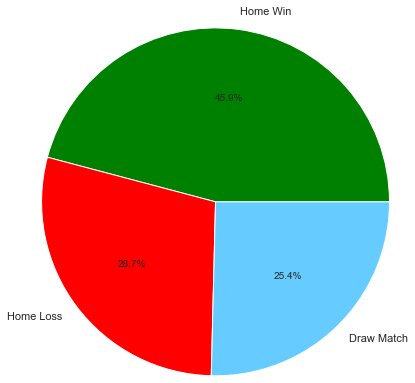

In [93]:
df_match_pie= df_match['home_match_result'].value_counts()
plt.pie(df_match_pie, labels=['Home Win', 'Home Loss', 'Draw Match'], colors=['green','red','#66CCFF'], autopct='%1.1f%%',radius=2);

The pie chart is simply telling that a team is most likely to win a match if they play home. Is that correct for each league?

In [94]:
df_league_win = df_match.loc[df_match['home_match_result']=='win',:].groupby(['league_name']).count()['home_match_result']
df_league_loss = df_match.loc[df_match['home_match_result']=='loss',:].groupby(['league_name']).count()['home_match_result']
df_league_draw = df_match.loc[df_match['home_match_result']=='draw',:].groupby(['league_name']).count()['home_match_result']

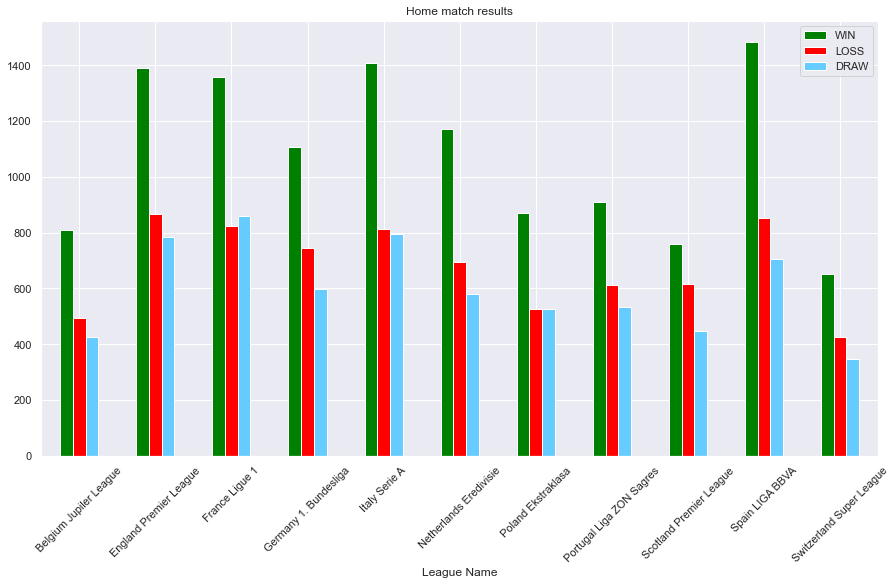

In [95]:
home_match_res = pd.concat([df_league_win,df_league_loss,df_league_draw], axis=1,keys=['WIN','LOSS','DRAW'])
home_match_res.plot(kind='bar', figsize=(15,8), color=['green','red','#66CCFF'], title='Home match results'
                    , xlabel='League Name', fontsize=11, rot=45);

Obviously, the home team is likely to win among all leagues. To be precise, we will take season 2012/2013 as an example.

In [96]:
df_league_win = df_match.loc[df_match['home_match_result']=='win',:].loc[df_match['season']=='2012/2013',:].groupby(['league_name']).count()['home_match_result']
df_league_loss = df_match.loc[df_match['home_match_result']=='loss',:].loc[df_match['season']=='2012/2013',:].groupby(['league_name']).count()['home_match_result']
df_league_draw = df_match.loc[df_match['home_match_result']=='draw',:].loc[df_match['season']=='2012/2013',:].groupby(['league_name']).count()['home_match_result']


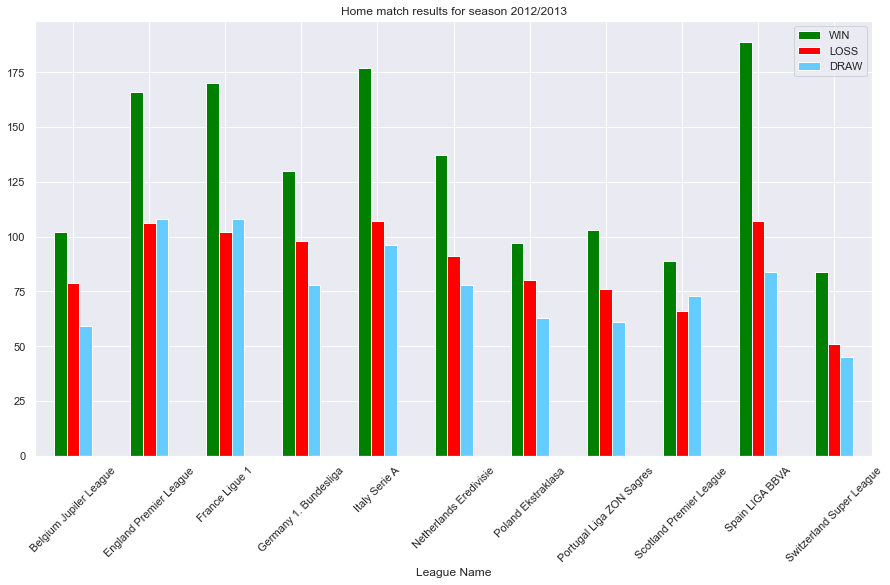

In [97]:
home_match_res = pd.concat([df_league_win,df_league_loss,df_league_draw], axis=1,keys=['WIN','LOSS','DRAW'])
home_match_res.plot(kind='bar', figsize=(15,8), color=['green','red','#66CCFF'], title='Home match results for season 2012/2013'
                    , xlabel='League Name', fontsize=11, rot=45);

There is no doubt that being home playing with the encouragment of your fans on your land is a great motive to win the match. But what are other parameters from attributes of a team?. To know that, lets see the most winning team among all leagues and accordingly we can have a look on their attributes.

### What are the top winning teams?

In [98]:
df_match['winner_team_name']=None

In [99]:
for z in df_match.index:
    if df_match.loc[z,'home_team_goal']>df_match.loc[z,'away_team_goal']:
        df_match.loc[z,'winner_team_name']=df_match.loc[z,'home_team_name']
    elif df_match.loc[z,'home_team_goal']<df_match.loc[z,'away_team_goal']:
        df_match.loc[z,'winner_team_name']=df_match.loc[z,'away_team_name']
    else:
        df_match.loc[z,'winner_team_name']='draw'

In [100]:
df_match.head()

,country_name,league_name,season,stage,home_team_name,away_team_name,home_team_goal,away_team_goal,home_match_result,winner_team_name
0,Belgium,Belgium Jupiler League,2008/2009,1,KRC Genk,Beerschot AC,1,1,draw,draw
1,Belgium,Belgium Jupiler League,2008/2009,1,SV Zulte-Waregem,Sporting Lokeren,0,0,draw,draw
2,Belgium,Belgium Jupiler League,2008/2009,1,KSV Cercle Brugge,RSC Anderlecht,0,3,loss,RSC Anderlecht
3,Belgium,Belgium Jupiler League,2008/2009,1,KAA Gent,RAEC Mons,5,0,win,KAA Gent
4,Belgium,Belgium Jupiler League,2008/2009,1,FCV Dender EH,Standard de Liège,1,3,loss,Standard de Liège


Now we get the most winning teams regardless being home or away. We will have to remove the Draw matches from the output.

In [101]:
df_winner = df_match['winner_team_name'].value_counts().head(11)
df_winner.drop(index=['draw'],inplace=True)


<a id="winning team"></a>

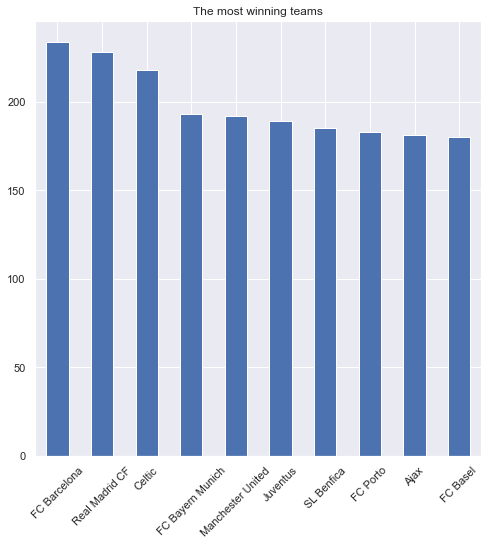

In [102]:
df_winner.plot(kind='bar', title='The most winning teams', rot=45, figsize=(8,8), grid=True);

The most winning team is FC Barcelona and comes at second place Real Madrid CF. Now let's put this aside and explore the team attributes in deep.

A quick corrolation insights can be found in the below table. Apparently, there is relation between the following attributes:
* **buildUpPlaySpeed** & **buildUpPlayPassing**
* **defencePressure** & **defenceAggression**
* **defenceTeamWidth** & **defencePressure**

In [103]:
df_team_att.corr()

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
buildUpPlaySpeed,1.000000,0.395536,0.319141,0.191648,0.072046,0.046384,0.160518,0.066988
buildUpPlayPassing,0.395536,1.000000,0.220391,0.231131,-0.077293,-0.050478,0.122501,0.063173
chanceCreationPassing,0.319141,0.220391,1.000000,0.246493,0.112449,0.203147,0.145161,0.150115
chanceCreationCrossing,0.191648,0.231131,0.246493,1.000000,-0.012666,0.087089,0.098783,0.131469
chanceCreationShooting,0.072046,-0.077293,0.112449,-0.012666,1.000000,0.185587,0.116477,0.129115
defencePressure,0.046384,-0.050478,0.203147,0.087089,0.185587,1.000000,0.422492,0.508460
defenceAggression,0.160518,0.122501,0.145161,0.098783,0.116477,0.422492,1.000000,0.243141
defenceTeamWidth,0.066988,0.063173,0.150115,0.131469,0.129115,0.508460,0.243141,1.000000


### What are the team attributes contributing the most in a winning team?

Now we are going to plot a scatter for the team attributes **buildUpPlaySpeed** & **buildUpPlayPassing** to see the correlation.

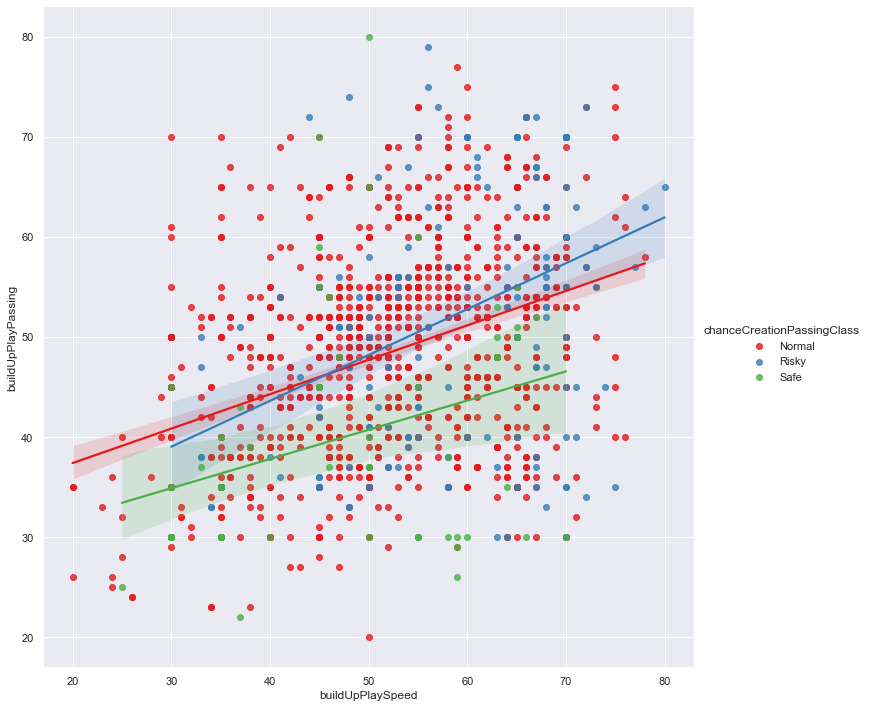

In [104]:
sns.set_theme(color_codes=True)

sns.lmplot(x="buildUpPlaySpeed", y="buildUpPlayPassing",hue='chanceCreationPassingClass',data= df_team_att, 
           height=10, palette='Set1');


The PlaySpead scaling at x-axis refers to the speed of play from slow to fast. The PlayPassing scaling at y-axis refers to the passes length from short to long. 

The chart says the more the speed of play, the longer the passes between team players. It is also seen that slow play speed has chances to create risky passes as well as safe passes. Amazingly, there are teams have chances to create risky passes at high play speed . 

The next figure shows the relation between the PlaySpeed at x-axis and the CreationPassing at the y-axis. Low CreationPassing scalling refers to safe passes class while the upper scalling is risky passes.

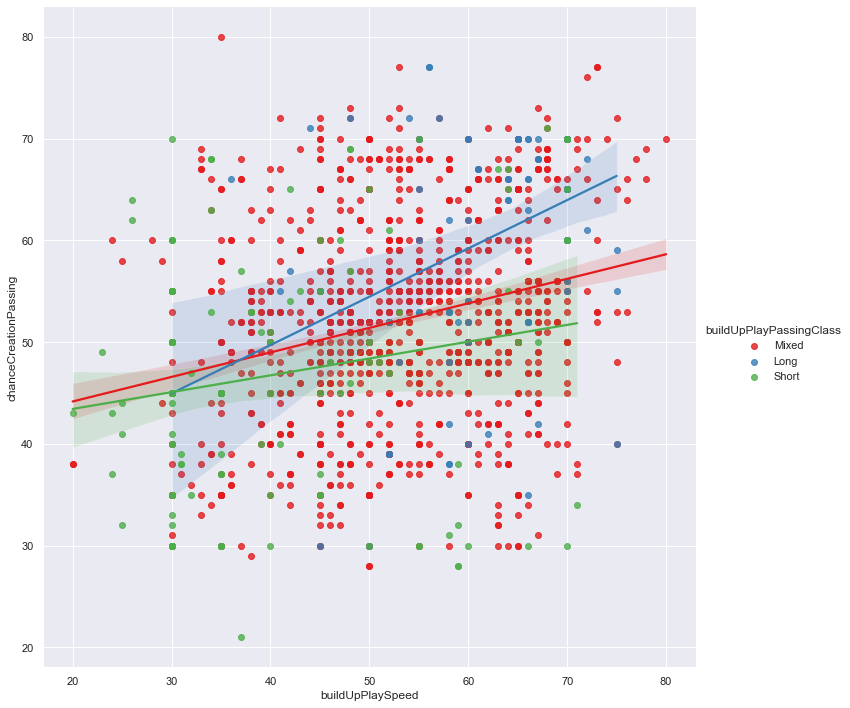

In [105]:
sns.set_theme(color_codes=True)

sns.lmplot(x="buildUpPlaySpeed", y="chanceCreationPassing",hue='buildUpPlayPassingClass',data= df_team_att, 
           height=10, palette='Set1');

We will look at teams with higher play speed. To observe that, the higher mean of play speed has to be calculated. The following bar chart will tell us that.
<a id="play speed"></a>

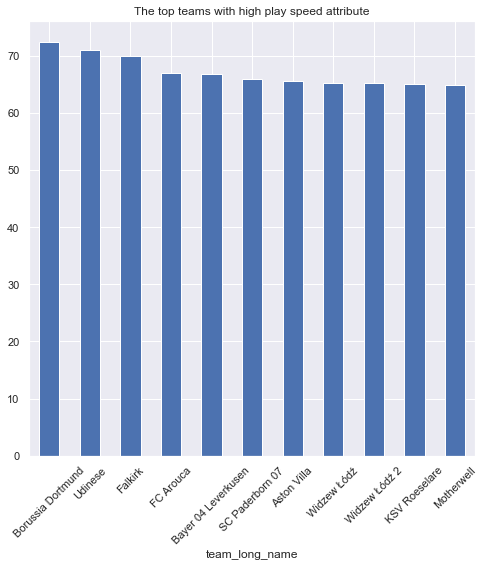

In [106]:
df_team_att.groupby(['team_long_name']).mean().sort_values(by=['buildUpPlaySpeed'], ascending=False)['buildUpPlaySpeed'].head(
    11).plot(kind='bar', title='The top teams with high play speed attribute', figsize=(8,8), rot=45);

Non of the top winners are among the high speed teams in play. 

Let's see the next correlations between **defencePressure** , **defenceAggression** & **defenceTeamWidth** to see if there is any attribute contribute the most in being a winning team.

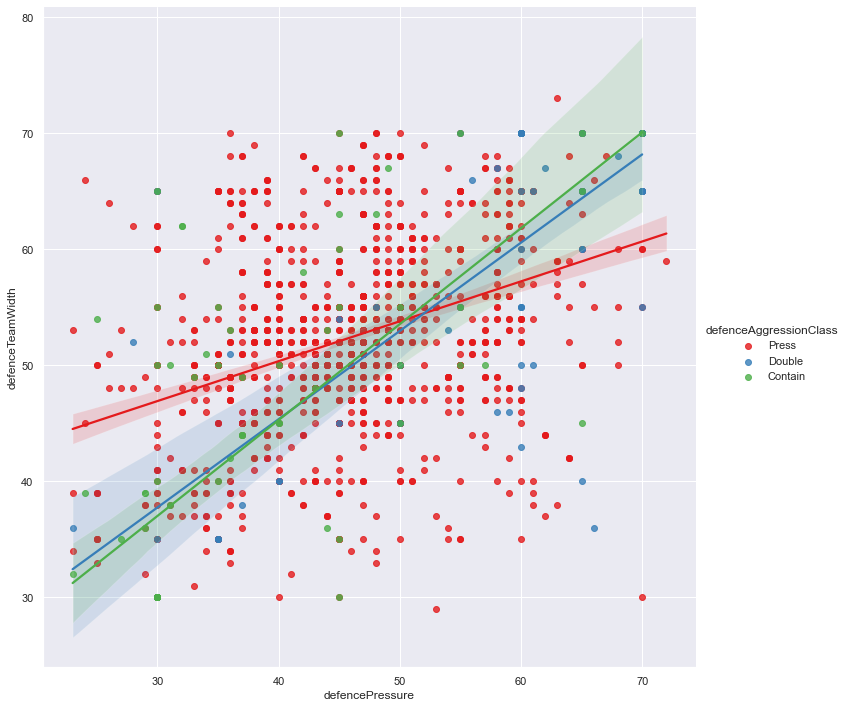

In [107]:
sns.lmplot(x="defencePressure", y="defenceTeamWidth",hue='defenceAggressionClass',data= df_team_att, 
           height=10, palette='Set1');

It can be seen from the above chart that a high defense pressure is depending on a wide defense team with a double or contain aggression defense.

Similarily, We will look at teams with higher defense pressure mean. The following bar chart will tell us that. 
<a id="defense pressure"></a>

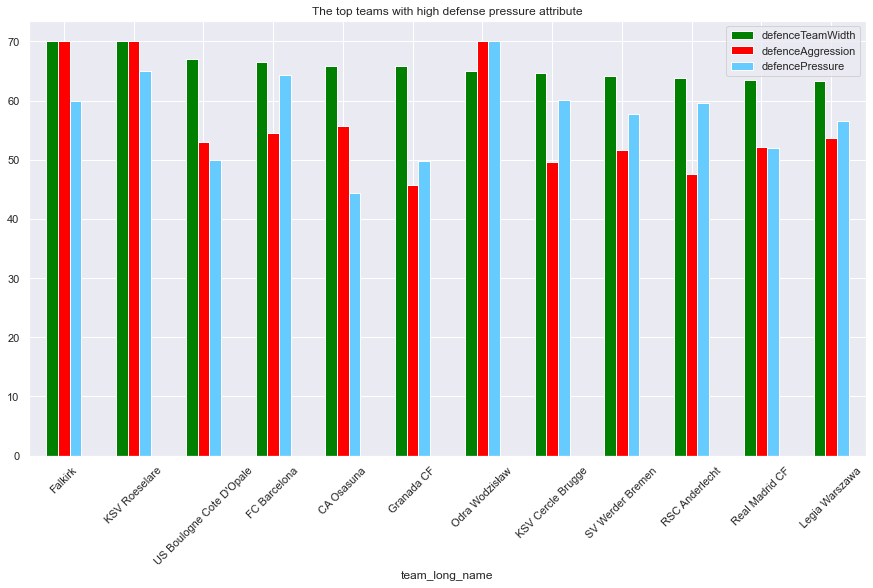

In [108]:
df_team_att.groupby(['team_long_name']).mean().sort_values(by=['defenceTeamWidth'], ascending=False).loc[:,['defenceTeamWidth','defenceAggression','defencePressure']].head(
    12).plot(kind='bar', title='The top teams with high defense pressure attribute', figsize=(15,8), color=['green','red','#66CCFF'], rot=45);

FC Barcelona and Real Madrid CF are among the top teams to defend their space and prevent a goal-scoring chance. I assume this leads, eventually, to winning the match if the opposite team is a mild defender. That means a winning team needs not to be a strong attacker as high as a defender while investing the mistakes of opposite team defense can lead to a successful goal-scoring chance.

A deep look at the team attributes of FC Barcelona and Real Madrid CF can tell alot. Are they close in the attributes as they are in the winning matches counts? Let's see.

In [109]:
df_team_att.loc[df_team_att['team_long_name'].isin(('FC Barcelona','Real Madrid CF'))].groupby(['team_long_name']).mean()

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
team_long_name,,,,,,,,
FC Barcelona,35.833333,34.000000,45.166667,33.333333,53.0,64.333333,54.500000,66.5
Real Madrid CF,50.666667,38.666667,67.500000,53.833333,69.0,52.000000,52.166667,63.5


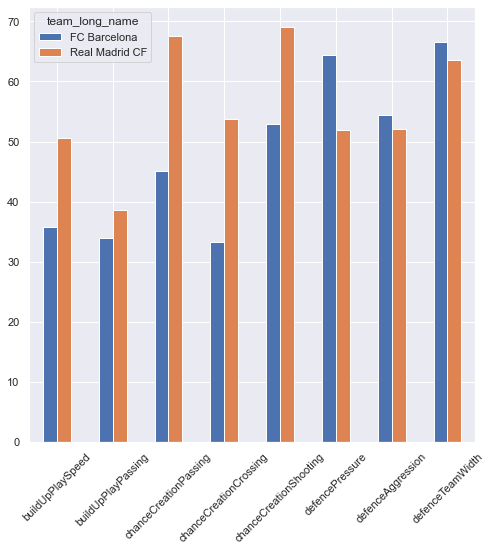

In [110]:
df_team_att.loc[df_team_att['team_long_name'].isin(('FC Barcelona','Real Madrid CF'))].groupby(
    ['team_long_name']).mean().T.plot(kind='bar', figsize=(8,8), rot=45);

Actually, I anticipated they would have similarities in many attributes, specially, they have won almost the same number of mathes. Apparently, Real Madrid CF is way overpassing FC Barcelona in all attributes except for the defensive attributes which FC Barcelona is at top. 

Do you think FC Barcelona was lucky to win as I think now?!

### Who are the top rated players among the world? are they playing in the top winning teams?

We will find the answer for these questions by getting the higher overall rating players. This will require the player attriutes DataFrame to be called and sorted descendingly by the **overall_rating**. For that, the mean **overall_rating** for each player is calculated.

In [111]:
df_player_rating = df_player_att.groupby(['player_api_id']).mean().sort_values(by='overall_rating', ascending=False).head(5)
df_player_rating

,overall_rating
player_api_id,
30981,92.192308
30893,91.280000
30924,88.458333
30955,88.320000
35724,88.285714


The **player_api_id** needs to be replaced with the player name.

In [112]:
def p_name(dfx):
    dfx['player_name']=None
    for i in dfx.index:
        playerid = i
        playername = list(df_player[df_player['player_api_id'] == playerid].loc[:,'player_name'])[0]
        
        dfx.loc[i,'player_name'] = playername
    dfx = dfx.reset_index()
    dfx = dfx.drop(columns='player_api_id')
    return dfx

In [113]:
df_player_rating = p_name(df_player_rating)


Let's see the top rated players in the world.<a id="top rated players"></a>

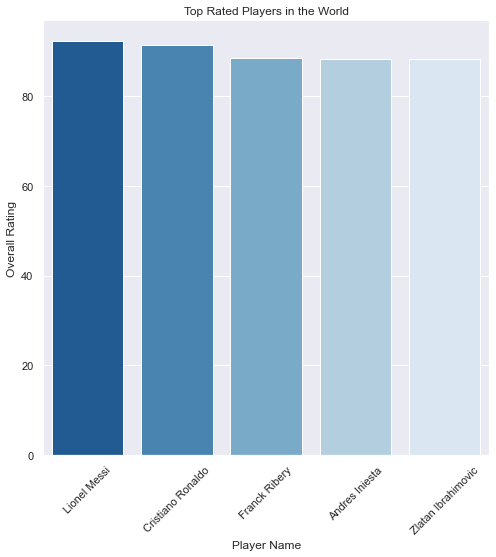

In [114]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x="player_name", y="overall_rating", data=df_player_rating, palette="Blues_r")
ax.set_xlabel("Player Name")
ax.set_ylabel("Overall Rating")
plt.title('Top Rated Players in the World')
plt.xticks(rotation = 45);

The top rated players actually play for the most winning teams. This is a great parameter contributing in a team to win a match. Similarily, if a team wants to win matches, it has to bring the top rated players to play within its team.

<a id='conclusions'></a>
## Conclusions

From the previous exploratory data analysis, it can be concluded that teams are most likely to win matches if they play in their land. A home team has a probability to <a href="#home win">win by 45%</a> . While the home team may loose or a match ends in a draw by 28%.

The <a href="#winning team">most winning team</a> is FC Barcelona and comes at second place Real Madrid CF. These teams include the <a href="#top rated players">top rated players</a> in the world such as Lionel Messi and Cristiano Ronaldo.

FC Barcelona and Real Madrid CF are among the <a href="#defense pressure">top teams to defend their space</a> and prevent a goal-scoring chance. However they are not among the <a href="#play speed">high play-speed teams</a>. A winning team needs not to be a strong attacker as high as a defender while investing the mistakes of opposite team defense can lead to a successful goal-scoring chance.

<a id='limitations'></a>
## Limitations

These conclusions are limited to the data available until 2016 within the dataset. The findings may differ if a more recent dataset is given. Moreover, the attributes of team players may be analyzed in deep to figure out more parameters contributing on  the chances a team to win.